# Classical ML Pipeline for Brain Age Prediction

This notebook is an exploratory, notebook-first workflow for classical (non-deep learning) models. It compares **PCA features** and **CNN embeddings**, then evaluates multiple classical regressors.

## Sections
1. Data loading and QC (T1 first)
2. Feature engineering (PCA vs CNN embeddings)
3. Model comparison (Ridge/ElasticNet, SVR, RandomForest, GradientBoosting)
4. Feature method comparison
5. Modality comparison
6. Error analysis


In [1]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import torch
import torch.nn as nn
from torchvision import models


In [ ]:
np.random.seed(42)

repo_root = Path.cwd().resolve()
if not (repo_root / "scripts").exists():
    repo_root = repo_root.parent
sys.path.insert(0, str(repo_root))

import os
from scripts import make_dataset

train_df = pd.read_csv(repo_root / "scripts" / "train_split.csv")
val_df = pd.read_csv(repo_root / "scripts" / "val_split.csv")
test_df = pd.read_csv(repo_root / "scripts" / "test_split.csv")

modalities = ["T1", "T2", "PD", "MRA"]

def load_split_arrays(df, modality):
    col_name = f"{modality}_file_name"
    img_dir = repo_root / "data" / "raw" / f"IXI_{modality}_png"
    X = np.array([
        make_dataset.load_image_as_array(os.path.join(img_dir, fname))
        for fname in df[col_name]
    ])
    y = df["AGE"].values
    return X, y


datasets = {}
for mod in modalities:
    X_train, y_train = load_split_arrays(train_df, mod)
    X_val, y_val = load_split_arrays(val_df, mod)
    X_test, y_test = load_split_arrays(test_df, mod)
    datasets[mod] = (X_train, y_train, X_val, y_val, X_test, y_test)
X_train, y_train, X_val, y_val, X_test, y_test = datasets["T1"]
print("Train/Val/Test sizes:", X_train.shape, X_val.shape, X_test.shape)


592 total records in CSV
550 records after dropping missing and duplicate filenames/ages
Train size: 330, Val size: 110, Test size: 110
Train/Val/Test sizes: (330, 224, 224) (110, 224, 224) (110, 224, 224)


## Data QC (T1)

Quick checks of the target distribution and some sample images.


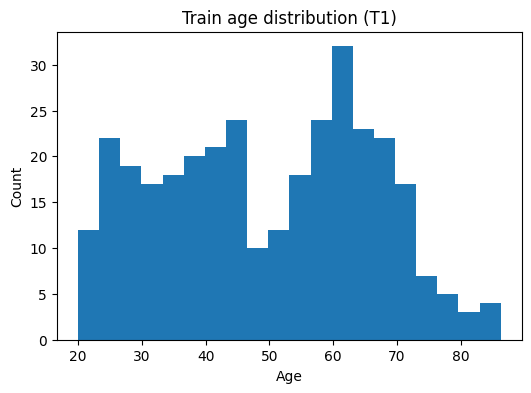

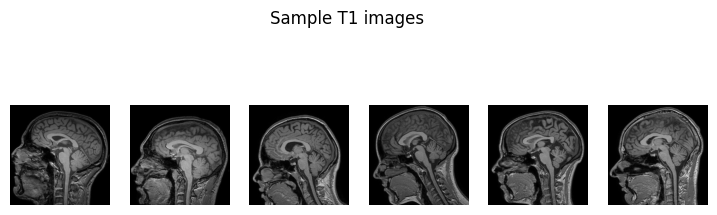

In [3]:
def plot_age_histogram(y, title="Age distribution"):
    plt.figure(figsize=(6, 4))
    plt.hist(y, bins=20)
    plt.title(title)
    plt.xlabel("Age")
    plt.ylabel("Count")
    plt.show()


def show_image_grid(X, n=6, title="Sample T1 images"):
    n = min(n, X.shape[0])
    plt.figure(figsize=(9, 3))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        ax.imshow(X[i], cmap="gray")
        ax.axis("off")
    plt.suptitle(title)
    plt.show()

plot_age_histogram(y_train, title="Train age distribution (T1)")
show_image_grid(X_train, n=6)


## Feature Engineering A: Flatten + PCA

We flatten each image into a vector, standardize, and apply PCA to reduce dimensionality before training classical models.


In [4]:
def flatten_images(X: np.ndarray) -> np.ndarray:
    return X.reshape(X.shape[0], -1)


def build_pca_pipeline(n_components: int) -> Pipeline:
    return Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=n_components, random_state=42))
    ])


def get_pca_features(X_train, X_val, X_test, n_components=100):
    X_train_flat = flatten_images(X_train)
    X_val_flat = flatten_images(X_val)
    X_test_flat = flatten_images(X_test)

    pca_pipe = build_pca_pipeline(n_components)
    X_train_pca = pca_pipe.fit_transform(X_train_flat)
    X_val_pca = pca_pipe.transform(X_val_flat)
    X_test_pca = pca_pipe.transform(X_test_flat)

    return X_train_pca, X_val_pca, X_test_pca, pca_pipe


## Feature Engineering B: CNN Embeddings (Fixed Backbone)

We use a pretrained CNN as a **fixed feature extractor** (no training). The CNN output embeddings become inputs to classical regression models.


In [5]:
def build_cnn_feature_extractor(device: str = "cpu"):
    weights = models.ResNet18_Weights.DEFAULT
    model = models.resnet18(weights=weights)
    model.fc = nn.Identity()
    model.eval()
    model.to(device)

    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    return model, mean, std


def preprocess_for_cnn(X: np.ndarray, device: str, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
    X = X.astype(np.float32) / 255.0
    X = np.repeat(X[:, None, :, :], 3, axis=1)
    X_tensor = torch.from_numpy(X).to(device)
    X_tensor = (X_tensor - mean) / std
    return X_tensor


def extract_cnn_features(X: np.ndarray, batch_size: int = 32, device: str = "cpu") -> np.ndarray:
    model, mean, std = build_cnn_feature_extractor(device=device)
    features = []

    with torch.no_grad():
        for i in range(0, X.shape[0], batch_size):
            batch = X[i:i + batch_size]
            batch_tensor = preprocess_for_cnn(batch, device=device, mean=mean, std=std)
            batch_feats = model(batch_tensor)
            features.append(batch_feats.cpu().numpy())

    return np.vstack(features)


## Model Comparison (Classical Regressors)

We evaluate multiple classical regressors on each feature type using RMSE/MAE/R².


In [6]:
def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}


def train_and_eval_models(X_train, y_train, X_val, y_val, X_test, y_test, models_dict):
    rows = []
    for name, model in models_dict.items():
        model.fit(X_train, y_train)
        val_pred = model.predict(X_val)
        test_pred = model.predict(X_test)

        val_metrics = evaluate_regression(y_val, val_pred)
        test_metrics = evaluate_regression(y_test, test_pred)

        rows.append({
            "model": name,
            "val_MSE": val_metrics["MSE"],
            "val_RMSE": val_metrics["RMSE"],
            "val_MAE": val_metrics["MAE"],
            "val_R2": val_metrics["R2"],
            "test_MSE": test_metrics["MSE"],
            "test_RMSE": test_metrics["RMSE"],
            "test_MAE": test_metrics["MAE"],
            "test_R2": test_metrics["R2"],
        })

    return pd.DataFrame(rows)


models_dict = {
    "Ridge": Ridge(alpha=1.0),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
}


## Run: PCA Features + Classical Models


In [7]:
pca_components_list = [50, 100, 150, 200]

pca_results = []
for n_components in pca_components_list:
    X_train_pca, X_val_pca, X_test_pca, pca_pipe = get_pca_features(
        X_train, X_val, X_test, n_components=n_components
    )
    df = train_and_eval_models(
        X_train_pca, y_train, X_val_pca, y_val, X_test_pca, y_test, models_dict
    )
    df["feature"] = "PCA"
    df["pca_components"] = n_components
    pca_results.append(df)

pca_results = pd.concat(pca_results, ignore_index=True)
print("Top PCA configs (by val_RMSE)")
pca_results.sort_values("val_RMSE").head(10)

best_pca_row = pca_results.sort_values("val_RMSE").iloc[0]
best_pca_components = int(best_pca_row["pca_components"])
best_model_name = best_pca_row["model"]
print("Best PCA config:")
print(best_pca_row)


/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:374: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:374: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:374: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:375: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:375: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/pyth

Top PCA configs (by val_RMSE)
Best PCA config:
model             ElasticNet
val_RMSE            13.41323
val_MAE            10.974156
val_R2              0.304174
test_RMSE          14.281217
test_MAE            12.33681
test_R2             0.275593
feature                  PCA
pca_components           150
Name: 5, dtype: object


/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/decomposition/_base.py:152: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/decomposition/_base.py:152: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/decomposition/_base.py:152: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/decomposition/_base.py:159: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/decomposition/_base.py:159: RuntimeWarning: over

## Tune Best PCA Model (Ridge vs ElasticNet)

We first pick the best PCA dimension, then select the better of Ridge vs ElasticNet, and finally tune that model's hyperparameters.


In [8]:
X_train_pca, X_val_pca, X_test_pca, _ = get_pca_features(
    X_train, X_val, X_test, n_components=best_pca_components
)

tuning_rows = []
if best_model_name == "Ridge":
    alpha_grid = [0.01, 0.1, 1.0, 3.0, 10.0, 30.0, 100.0]
    for alpha in alpha_grid:
        model = Ridge(alpha=alpha)
        model.fit(X_train_pca, y_train)
        val_pred = model.predict(X_val_pca)
        val_metrics = evaluate_regression(y_val, val_pred)
        tuning_rows.append({"model": "Ridge", "alpha": alpha, **val_metrics})

elif best_model_name == "ElasticNet":
    alpha_grid = [0.01, 0.1, 1.0, 3.0, 10.0]
    l1_ratio_grid = [0.1, 0.3, 0.5, 0.7, 0.9]
    for alpha in alpha_grid:
        for l1_ratio in l1_ratio_grid:
            model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
            model.fit(X_train_pca, y_train)
            val_pred = model.predict(X_val_pca)
            val_metrics = evaluate_regression(y_val, val_pred)
            tuning_rows.append({
                "model": "ElasticNet",
                "alpha": alpha,
                "l1_ratio": l1_ratio,
                **val_metrics,
            })

else:
    raise ValueError(f"Unexpected model: {best_model_name}")

tuning_results = pd.DataFrame(tuning_rows)
tuning_results = tuning_results.sort_values("RMSE")
print("Top tuning results (by val_RMSE)")
tuning_results.head(10)

best_tuned = tuning_results.iloc[0]
print("Best tuned params:")
print(best_tuned)

if best_model_name == "Ridge":
    models_dict[best_model_name] = Ridge(alpha=float(best_tuned["alpha"]))
else:
    models_dict[best_model_name] = ElasticNet(
        alpha=float(best_tuned["alpha"]),
        l1_ratio=float(best_tuned["l1_ratio"]),
        random_state=42,
    )

best_feature = "PCA"
best_model = best_model_name
best_n_components = best_pca_components


/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:374: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:374: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:374: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:375: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:375: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/pyth

Top tuning results (by val_RMSE)
Best tuned params:
model       ElasticNet
alpha              3.0
l1_ratio           0.7
RMSE         13.320308
MAE          10.925518
R2            0.313782
Name: 18, dtype: object


/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/decomposition/_base.py:152: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/decomposition/_base.py:152: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/decomposition/_base.py:152: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/decomposition/_base.py:159: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/decomposition/_base.py:159: RuntimeWarning: over

## Run: CNN Embeddings + Classical Models (Not used)

Instructor guidance: classical model section should **not** use CNN embeddings. Keep this section for reference, but skip execution.


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train_cnn = extract_cnn_features(X_train, batch_size=32, device=device)
X_val_cnn = extract_cnn_features(X_val, batch_size=32, device=device)
X_test_cnn = extract_cnn_features(X_test, batch_size=32, device=device)

cnn_results = train_and_eval_models(
    X_train_cnn, y_train, X_val_cnn, y_val, X_test_cnn, y_test, models_dict
)
cnn_results["feature"] = "CNN"
cnn_results["pca_components"] = None

cnn_results.sort_values("val_RMSE").head(10)
print("But we will skip CNN embeddings per instructor guidance.")
cnn_results = pd.DataFrame()


But we will skip CNN embeddings per instructor guidance.


/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:227: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/linear_model/_base.py:293: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/linear_model/_base.py:293: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-p

## Feature Method Comparison and Selection


In [10]:
all_results = pca_results.sort_values("val_RMSE")
all_results.head(10)

best_row = all_results.iloc[0]
print("Best PCA pipeline (by val_RMSE):")
print(best_row)


Best PCA pipeline (by val_RMSE):
model             ElasticNet
val_RMSE            13.41323
val_MAE            10.974156
val_R2              0.304174
test_RMSE          14.281217
test_MAE            12.33681
test_R2             0.275593
feature                  PCA
pca_components           150
Name: 5, dtype: object


## Modality Comparison (T1 / T2 / PD / MRA)

Use the best feature+model pipeline above, then re-run with four modalities to see which data group performs best.


In [11]:
def get_features_for_modality(modality, feature_type, n_components=100, device="cpu"):
    X_train_m, y_train_m, X_val_m, y_val_m, X_test_m, y_test_m = datasets[modality]

    if feature_type == "PCA":
        X_train_feat, X_val_feat, X_test_feat, _ = get_pca_features(
            X_train_m, X_val_m, X_test_m, n_components=n_components
        )
    elif feature_type == "CNN":
        X_train_feat = extract_cnn_features(X_train_m, batch_size=32, device=device)
        X_val_feat = extract_cnn_features(X_val_m, batch_size=32, device=device)
        X_test_feat = extract_cnn_features(X_test_m, batch_size=32, device=device)
    else:
        raise ValueError(f"Unknown feature type: {feature_type}")

    return X_train_feat, y_train_m, X_val_feat, y_val_m, X_test_feat, y_test_m


def train_eval_for_modality(modality, feature_type, model_name, n_components=100, device="cpu"):
    X_train_feat, y_train_m, X_val_feat, y_val_m, X_test_feat, y_test_m = get_features_for_modality(
        modality, feature_type, n_components=n_components, device=device
    )
    model = models_dict[model_name]
    model.fit(X_train_feat, y_train_m)

    val_pred = model.predict(X_val_feat)
    test_pred = model.predict(X_test_feat)

    val_metrics = evaluate_regression(y_val_m, val_pred)
    test_metrics = evaluate_regression(y_test_m, test_pred)

    return {
        "modality": modality,
        "feature": feature_type,
        "model": model_name,
        "val_RMSE": val_metrics["RMSE"],
        "val_MAE": val_metrics["MAE"],
        "val_R2": val_metrics["R2"],
        "test_RMSE": test_metrics["RMSE"],
        "test_MAE": test_metrics["MAE"],
        "test_R2": test_metrics["R2"],
    }

# Use best pipeline from earlier section
best_feature = best_row["feature"]
best_model = best_row["model"]
best_n_components = int(best_row["pca_components"]) if best_row["feature"] == "PCA" else None

device = "cuda" if torch.cuda.is_available() else "cpu"

modality_results = []
for modality in ["T1", "T2", "PD", "MRA"]:
    row = train_eval_for_modality(
        modality,
        best_feature,
        best_model,
        n_components=best_n_components if best_n_components is not None else 100,
        device=device,
    )
    modality_results.append(row)

modality_results = pd.DataFrame(modality_results)
modality_results.sort_values("val_RMSE")


/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:374: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:374: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:374: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:375: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:375: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/pyth

,modality,feature,model,val_RMSE,val_MAE,val_R2,test_RMSE,test_MAE,test_R2
1,T2,PCA,ElasticNet,11.392053,9.447678,0.498076,11.682464,9.956392,0.515246
0,T1,PCA,ElasticNet,13.320308,10.925518,0.313782,14.180601,12.341177,0.285765
2,PD,PCA,ElasticNet,13.601480,11.650411,0.284506,14.116083,12.117018,0.292249
3,MRA,PCA,ElasticNet,13.744535,11.690095,0.269376,14.885278,12.705809,0.213016


## Modality Combination Comparison (T1 vs T1+T2 vs T1+T2+PD vs T1+T2+PD+MRA)

We use the **best feature + model** from earlier and compare different **multi-modal combinations** to see if adding modalities improves performance.


In [12]:
def get_combo_features(modalities, feature_type, n_components=100, device="cpu"):
    feats = []
    y_train_m = y_val_m = y_test_m = None

    for modality in modalities:
        X_train_m, y_train_m, X_val_m, y_val_m, X_test_m, y_test_m = datasets[modality]
        if feature_type == "PCA":
            X_train_feat, X_val_feat, X_test_feat, _ = get_pca_features(
                X_train_m, X_val_m, X_test_m, n_components=n_components
            )
        elif feature_type == "CNN":
            X_train_feat = extract_cnn_features(X_train_m, batch_size=32, device=device)
            X_val_feat = extract_cnn_features(X_val_m, batch_size=32, device=device)
            X_test_feat = extract_cnn_features(X_test_m, batch_size=32, device=device)
        else:
            raise ValueError(f"Unknown feature type: {feature_type}")

        feats.append((X_train_feat, X_val_feat, X_test_feat))

    X_train_combo = np.concatenate([f[0] for f in feats], axis=1)
    X_val_combo = np.concatenate([f[1] for f in feats], axis=1)
    X_test_combo = np.concatenate([f[2] for f in feats], axis=1)

    return X_train_combo, y_train_m, X_val_combo, y_val_m, X_test_combo, y_test_m


def train_eval_for_combo(modalities, feature_type, model_name, n_components=100, device="cpu"):
    X_train_feat, y_train_m, X_val_feat, y_val_m, X_test_feat, y_test_m = get_combo_features(
        modalities, feature_type, n_components=n_components, device=device
    )
    model = models_dict[model_name]
    model.fit(X_train_feat, y_train_m)

    val_pred = model.predict(X_val_feat)
    test_pred = model.predict(X_test_feat)

    val_metrics = evaluate_regression(y_val_m, val_pred)
    test_metrics = evaluate_regression(y_test_m, test_pred)

    return {
        "modalities": "+".join(modalities),
        "feature": feature_type,
        "model": model_name,
        "val_RMSE": val_metrics["RMSE"],
        "val_MAE": val_metrics["MAE"],
        "val_R2": val_metrics["R2"],
        "test_RMSE": test_metrics["RMSE"],
        "test_MAE": test_metrics["MAE"],
        "test_R2": test_metrics["R2"],
    }

combo_sets = [
    ["T1"],
    ["T1", "T2"],
    ["T1", "T2", "PD"],
    ["T1", "T2", "PD", "MRA"],
]

combo_results = []
for combo in combo_sets:
    combo_results.append(
        train_eval_for_combo(
            combo,
            best_feature,
            best_model,
            n_components=best_n_components if best_n_components is not None else 100,
            device=device,
        )
    )

combo_results = pd.DataFrame(combo_results)
combo_results.sort_values("val_RMSE")


/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:374: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:374: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:374: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:375: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:375: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/pyth

,modalities,feature,model,val_RMSE,val_MAE,val_R2,test_RMSE,test_MAE,test_R2
2,T1+T2+PD,PCA,ElasticNet,11.028549,8.909120,0.529597,11.757805,9.877769,0.508974
3,T1+T2+PD+MRA,PCA,ElasticNet,11.090350,9.375013,0.524310,11.843740,9.821229,0.501770
1,T1+T2,PCA,ElasticNet,11.516815,9.431829,0.487022,11.685183,9.910612,0.515021
0,T1,PCA,ElasticNet,13.320308,10.925518,0.313782,14.180601,12.341177,0.285765


## Error Analysis (Top-5 Largest Errors)


/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:374: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:374: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:374: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:375: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/python3.11/site-packages/sklearn/utils/extmath.py:375: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/opt/homebrew/Caskroom/miniconda/base/envs/aipi540/lib/pyth

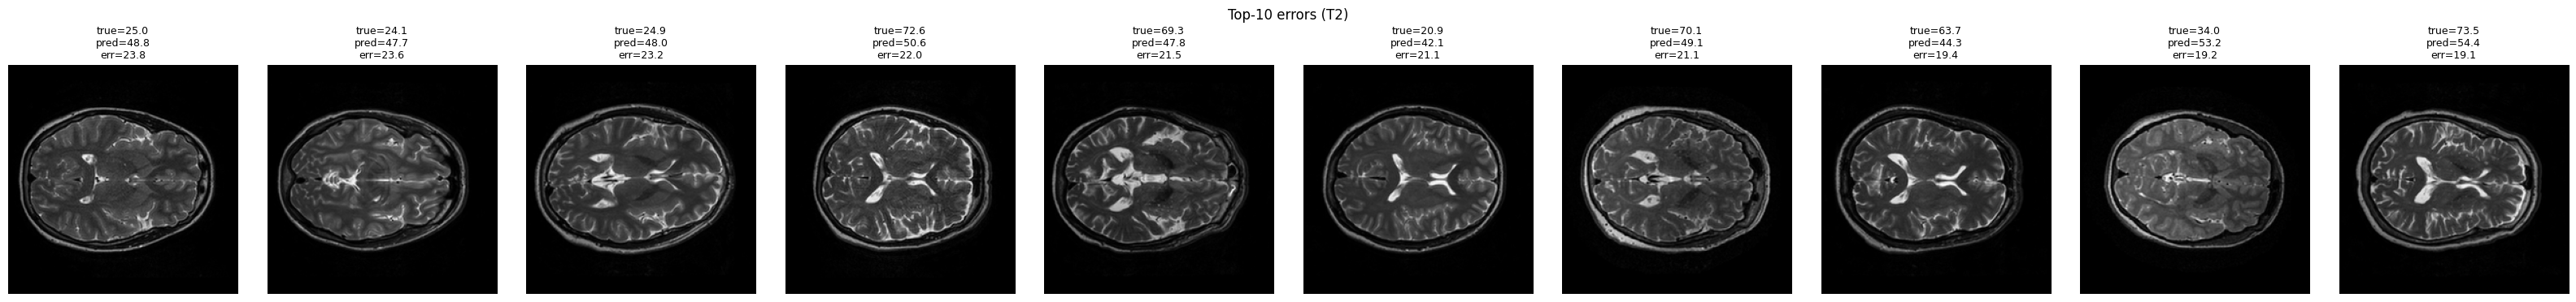

In [15]:
def top_k_errors(y_true, y_pred, k=5):
    df = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
    df["abs_error"] = (df["y_true"] - df["y_pred"]).abs()
    df["index"] = df.index
    return df.sort_values("abs_error", ascending=False).head(k)


def plot_error_images(X, error_df, title="Top errors"):
    n = len(error_df)
    fig, axes = plt.subplots(1, n, figsize=(3.2 * n, 3.6))
    if n == 1:
        axes = [axes]

    for ax, row in zip(axes, error_df.itertuples(index=False)):
        idx = int(row.index)
        ax.imshow(X[idx], cmap="gray")
        ax.axis("off")
        ax.set_title(
            f"true={row.y_true:.1f}\n"
            f"pred={row.y_pred:.1f}\n"
            f"err={row.abs_error:.1f}",
            fontsize=9,
        )

    fig.suptitle(title, fontsize=12, y=1.02)
    fig.tight_layout()
    plt.show()

# Use the best modality from modality_results
best_modality = modality_results.sort_values("val_RMSE").iloc[0]["modality"]

X_train_m, y_train_m, X_val_m, y_val_m, X_test_m, y_test_m = datasets[best_modality]

if best_feature == "PCA":
    X_train_feat, X_val_feat, X_test_feat, _ = get_pca_features(
        X_train_m, X_val_m, X_test_m, n_components=best_n_components
    )
else:
    X_train_feat = extract_cnn_features(X_train_m, batch_size=32, device=device)
    X_val_feat = extract_cnn_features(X_val_m, batch_size=32, device=device)
    X_test_feat = extract_cnn_features(X_test_m, batch_size=32, device=device)

model = models_dict[best_model]
model.fit(X_train_feat, y_train_m)

test_pred = model.predict(X_test_feat)
error_examples = top_k_errors(y_test_m, test_pred, k=10)
error_examples

plot_error_images(X_test_m, error_examples, title=f"Top-10 errors ({best_modality})")
